In [2]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

from pathlib import Path
from typing import Tuple
from tempfile import TemporaryDirectory
import warnings

import pandas as pd
from spacy import displacy
from typing import Optional
from spacy.tokens import Doc
from meddocan.data import meddocan_zip, ArchiveFolder
from meddocan.data.containers import BratAnnotations
from meddocan.data.docs_iterators import GsDocs
from meddocan.language.pipeline import meddocan_pipeline
from meddocan.data import meddocan_url, meddocan_zip, ArchiveFolder
from meddocan.data.docs_iterators import BratAnnotations, GsDocs
from meddocan.data.utils import set_ents_from_brat_spans
from meddocan.data.corpus import MEDDOCAN
from presentation.utils import (
    get_brat_annotation_from_github,
    glue_iob_label,
    display_script,
    visualize_conll03,
)
from meddocan.evaluation.classes import (
    EvaluateSubtrack1,
    EvaluateSubtrack2,
    EvaluateSubtrack2merged,
)


warnings.simplefilter(action="ignore", category=FutureWarning)

# MEDDOCAN: Anonimización aplicada al ámbito médico

## Introducción

* Medical Document Anonymization Track (track 9 of the <abbr title="Iberian Languages Evaluation Forum 2019"> [IberLEF 2019](http://ceur-ws.org/Vol-2421/)).</abbr>.

    Detectar automáticamente la información sanitaria protegida (PHI)

* ¿Como?

    Name Entity Recognition con métodos de **Transfer Learning** basados en los **Transformers**


## Dataset

* Visualización de los datos

![Figure 1: An example of MEDDOCAN annotation visualized using the BRAT annotation interface.](https://temu.bsc.es/meddocan/wp-content/uploads/2019/03/image-1-1024x922.png)

- Los datos son anotados con la herramienta **brat** y son almacenados al **formato standoff**. 
- A cada documento de texto del sistema le corresponde un fichero de anotaciones. Ambos están asociados por la convención de que su nombre base (nombre de fichero sin sufijo) es el mismo: por ejemplo, el fichero *DOC-1000.ann* contiene anotaciones para el fichero *DOC-1000.txt*.

* Numero de documentos

| corpus | Train | Dev | Test |
| ------ | ----- | --- | ---- |
| Qt     | 500   | 250 | 250  |

* Distribución del tipo de entidad entre los juegos de datos

|               Tipo               | Train | Dev | Test | Total |
| :------------------------------: | :---: | :-: | :--: | :---: |
|            TERRITORIO            | 1875  | 987 | 956  | 3818  |
|              FECHAS              | 1231  | 724 | 611  | 2566  |
|      EDAD SUJETO ASISTENCIA      | 1035  | 521 | 518  | 2074  |
|     NOMBRE SUJETO ASISTENCIA     | 1009  | 503 | 502  | 2014  |
|    NOMBRE PERSONAL SANITARIO     | 1000  | 497 | 501  | 1998  |
|      SEXO SUJETO ASISTENCIA      |  925  | 455 | 461  | 1841  |
|              CALLE               |  862  | 434 | 413  | 1709  |
|               PAIS               |  713  | 347 | 363  | 1423  |
|       ID SUJETO ASISTENCIA       |  567  | 292 | 283  | 1142  |
|        CORREO ELECTRONICO        |  469  | 241 | 249  |  959  |
| ID TITULACION PERSONAL SANITARIO |  471  | 226 | 234  |  931  |
|         ID ASEGURAMIENTO         |  391  | 194 | 198  |  783  |
|             HOSPITAL             |  255  | 140 | 130  |  525  |
|   FAMILIARES SUJETO ASISTENCIA   |  243  | 92  |  81  |  416  |
|           INSTITUCION            |  98   | 72  |  67  |  237  |
|     ID CONTACTO ASISTENCIAL      |  77   | 32  |  39  |  148  |
|         NUMERO TELEFONO          |  58   | 25  |  26  |  109  |
|            PROFESION             |  24   |  4  |  9   |  37   |
|            NUMERO FAX            |  15   |  6  |  7   |  28   |
|     OTROS SUJETO ASISTENCIA      |   9   |  6  |  7   |  22   |
|           CENTRO SALUD           |   6   |  2  |  6   |  14   |
|   ID EMPLEO PERSONAL SANITARIO   |   0   |  1  |  0   |   1   |
| IDENTIF VEHICULOS NRSERIE PLACAS |   0   |  0  |  0   |   0   |
|   IDENTIF DISPOSITIVOS NRSERIE   |   0   |  0  |  0   |   0   |
|     NUMERO BENEF PLAN SALUD      |   0   |  0  |  0   |   0   |
|             URL WEB              |   0   |  0  |  0   |   0   |
|       DIREC PROT INTERNET        |   0   |  0  |  0   |   0   |
|        IDENTF BIOMETRICOS        |   0   |  0  |  0   |   0   |
|       OTRO NUMERO IDENTIF        |   0   |  0  |  0   |   0   |

* Implementación

El paquete ``meddocan.data`` proporciona clases y funciones para tratar con los conjuntos de datos originales de
meddocan en la web.

- `meddocan.data.meddocan_url` contiene el enlace url para llegar a las carpetas de datos comprimidas.

In [3]:
meddocan_url

MeddocanUrl(sample='http://temu.bsc.es/meddocan/wp-content/uploads/2019/03/sample-set.zip', train='http://temu.bsc.es/meddocan/wp-content/uploads/2019/03/train-set.zip', dev='http://temu.bsc.es/meddocan/wp-content/uploads/2019/04/dev-set-1.zip', test='http://temu.bsc.es/meddocan/wp-content/uploads/2019/05/test-set.zip', background='http://temu.bsc.es/meddocan/wp-content/uploads/2019/10/background-set.zip', base='http://temu.bsc.es/meddocan/wp-content/uploads/2019')

* `meddocan.data.meddocan_zip` obtiene el par de archivos brat para
una carpeta determinada del conjunto de datos en caché a través de su método ``brat_files``.

In [4]:
brat_files_pairs = meddocan_zip.brat_files(ArchiveFolder.train)

In [5]:
n = 0
for _ in meddocan_zip.brat_files(ArchiveFolder.train):
    n += 1
print(f"Hay {n} documentos en el set de entrenamiento")

Hay 500 documentos en el set de entrenamiento


In [6]:
brat_files_pair = next(brat_files_pairs)

In [7]:
brat_files_pair.txt

Path('/home/wave/.meddocan/datasets/meddocan/train-set.zip', 'train/brat/S0004-06142005000500011-1.txt')

In [8]:
brat_files_pair.ann

Path('/home/wave/.meddocan/datasets/meddocan/train-set.zip', 'train/brat/S0004-06142005000500011-1.ann')

Visualizamos los datos brutos

In [9]:
brat_annotations = BratAnnotations.from_brat_files(brat_files_pair)

- El texto

> :pencil: Vamos a coger este texto como ejemplo a lo largo de la presentación

In [10]:
text = brat_annotations.text
print(text[:600])

Datos del paciente.
Nombre:  Ernesto.
Apellidos: Rivera Bueno.
NHC: 368503.
NASS: 26 63514095.
Domicilio:  Calle Miguel Benitez 90.
Localidad/ Provincia: Madrid.
CP: 28016.
Datos asistenciales.
Fecha de nacimiento: 03/03/1946.
País: España.
Edad: 70 años Sexo: H.
Fecha de Ingreso: 12/12/2016.
Médico:  Ignacio Navarro Cuéllar NºCol: 28 28 70973.
Informe clínico del paciente: Paciente de 70 años de edad, minero jubilado, sin alergias medicamentosas conocidas, que presenta como antecedentes personales: accidente laboral antiguo con fracturas vertebrales y costales; intervenido de enfermedad de Du


- Las anotaciones

Las anotaciones siguen la misma estructura básica:   
Cada línea contiene una anotación, y cada anotación recibe un ID que aparece en primer lugar en la línea, separado del resto de la anotación por un único carácter TAB. El resto de la estructura varía según el tipo de anotación.

In [11]:
print(
    brat_files_pair.ann.root.open(brat_files_pair.ann.at)
    .read()
    .decode("utf-8")
)

T1	FECHAS 215 225	03/03/1946
T2	CORREO_ELECTRONICO 2421 2439	nnavcu@hotmail.com
T3	PAIS 2406 2412	España
T4	TERRITORIO 2398 2404	Madrid
T5	TERRITORIO 2392 2397	28036
T6	CALLE 2365 2391	c/ del Abedul 5-7, 2º dcha
T7	NOMBRE_PERSONAL_SANITARIO 303 326	Ignacio Navarro Cuéllar
T8	NOMBRE_PERSONAL_SANITARIO 2341 2364	Ignacio Navarro Cuéllar
T9	EDAD_SUJETO_ASISTENCIA 389 396	70 años
T10	ID_TITULACION_PERSONAL_SANITARIO 334 345	28 28 70973
T11	FECHAS 282 292	12/12/2016
T12	SEXO_SUJETO_ASISTENCIA 261 262	H
T13	EDAD_SUJETO_ASISTENCIA 247 254	70 años
T14	PAIS 233 239	España
T15	TERRITORIO 166 171	28016
T16	TERRITORIO 154 160	Madrid
T17	CALLE 107 130	Calle Miguel Benitez 90
T18	ID_ASEGURAMIENTO 82 93	26 63514095
T19	ID_SUJETO_ASISTENCIA 68 74	368503
T20	NOMBRE_SUJETO_ASISTENCIA 49 61	Rivera Bueno
T21	NOMBRE_SUJETO_ASISTENCIA 29 36	Ernesto



- Las anotaciones

In [12]:
brat_spans = brat_annotations.brat_spans
brat_spans

[BratSpan(id='T1', entity_type='FECHAS', start=215, end=225, text='03/03/1946'),
 BratSpan(id='T2', entity_type='CORREO_ELECTRONICO', start=2421, end=2439, text='nnavcu@hotmail.com'),
 BratSpan(id='T3', entity_type='PAIS', start=2406, end=2412, text='España'),
 BratSpan(id='T4', entity_type='TERRITORIO', start=2398, end=2404, text='Madrid'),
 BratSpan(id='T5', entity_type='TERRITORIO', start=2392, end=2397, text='28036'),
 BratSpan(id='T6', entity_type='CALLE', start=2365, end=2391, text='c/ del Abedul 5-7, 2º dcha'),
 BratSpan(id='T7', entity_type='NOMBRE_PERSONAL_SANITARIO', start=303, end=326, text='Ignacio Navarro Cuéllar'),
 BratSpan(id='T8', entity_type='NOMBRE_PERSONAL_SANITARIO', start=2341, end=2364, text='Ignacio Navarro Cuéllar'),
 BratSpan(id='T9', entity_type='EDAD_SUJETO_ASISTENCIA', start=389, end=396, text='70 años'),
 BratSpan(id='T10', entity_type='ID_TITULACION_PERSONAL_SANITARIO', start=334, end=345, text='28 28 70973'),
 BratSpan(id='T11', entity_type='FECHAS', sta

### Preprocessamiento

Para empezar llamamos nuestro pipeline ``meddocan.language.pipeline.meddocan_pipeline`` hecho con la libreria [spaCy](https://spacy.io/) y miramos sus componentes.

In [13]:
nlp = meddocan_pipeline()
pd.DataFrame(nlp.pipe_names, columns=["componentes"]).T

,0,1,2,3
componentes,missaligned_splitter,line_sentencizer,predictor,write_methods


Vamos a hacer pasar nuestro texto de ejemplo por el ``meddocan_pipeline`` y ver el efecto de cada componente.

In [14]:
doc = nlp(text)

#### 1. Tokenización

> :pencil: Un tokenizador se encarga de preparar las entradas para un modelo. 

In [15]:
[token.orth_ for token in doc[:30]]

['Datos',
 'del',
 'paciente',
 '.',
 '\n',
 'Nombre',
 ':',
 ' ',
 'Ernesto',
 '.',
 '\n',
 'Apellidos',
 ':',
 'Rivera',
 'Bueno',
 '.',
 '\n',
 'NHC',
 ':',
 '368503',
 '.',
 '\n',
 'NASS',
 ':',
 '26',
 '63514095',
 '.',
 '\n',
 'Domicilio',
 ':']

#### 2. Casos especiales ➟ missaligned_splitter

> :warning: El principio de cada entidad debe coincidir con el principio de un token y su fin con el fin de un token.

In [16]:
[token for token in nlp("DREnric Lopez")]

[DR, Enric, Lopez]

#### 3. Partición del documento en párrafos ➟ line_sentencizer

> :pencil: Los modelos de NER aceptan frases compuestas de token como entrada

In [17]:
pd.set_option("display.max_colwidth", 100)

df = pd.DataFrame([sent.text for sent in doc.sents][:10], columns=["párrafo"])
df.style.set_properties(**{"text-align": "left"})

,párrafo
0,Datos del paciente.
1,Nombre: Ernesto.
2,Apellidos: Rivera Bueno.
3,NHC: 368503.
4,NASS: 26 63514095.
5,Domicilio: Calle Miguel Benitez 90.
6,Localidad/ Provincia: Madrid.
7,CP: 28016.
8,Datos asistenciales.
9,Fecha de nacimiento: 03/03/1946.


#### 4. Asociar entidades al Doc ➟ predictor

En una primera fase no tenemos modelos con el cual hacer predicciones.
Entonces añadimos la entidades a nuestro objeto ``doc`` usando la function ``meddocan.data.utils.set_ents_from_brat_spans``.

In [18]:
doc = set_ents_from_brat_spans(doc, brat_spans=brat_spans)
displacy.render(doc[:100], style="ent")

#### Serializar las anotaciones ➟ write_methods

Para la evaluación, se puede escribir los datos al formato **Brat** gracias al método ``_.to_ann``.

> :bulb: Una vez un modelo entrenado, cada documento se puede serializar a formato **formato standoff**.

In [19]:
with TemporaryDirectory() as td:
    pth = Path(td, "file.txt")
    doc._.to_ann(pth)
    for i, line in enumerate(pth.read_text().split("\n")):
        print(line)
        if i > 10:
            break

T_0	NOMBRE_SUJETO_ASISTENCIA 29 36	Ernesto
T_1	NOMBRE_SUJETO_ASISTENCIA 49 61	Rivera Bueno
T_2	ID_SUJETO_ASISTENCIA 68 74	368503
T_3	ID_ASEGURAMIENTO 82 93	26 63514095
T_4	CALLE 107 130	Calle Miguel Benitez 90
T_5	TERRITORIO 154 160	Madrid
T_6	TERRITORIO 166 171	28016
T_7	FECHAS 215 225	03/03/1946
T_8	PAIS 233 239	España
T_9	EDAD_SUJETO_ASISTENCIA 247 254	70 años
T_10	SEXO_SUJETO_ASISTENCIA 261 262	H
T_11	FECHAS 282 292	12/12/2016


Para el entrenamiento, los datos se escriben al formato **conll03** gracias al método ``_.to_connl03``.

> :bulb: Cada documento se puede serializar a formato **IOB**.

In [20]:
with TemporaryDirectory() as td:
    pth = Path(td, "file.txt")
    doc._.to_connl03(pth)
    for i, line in enumerate(pth.read_text().split("\n")):
        print(line)
        if i > 10:
            break

Datos O
del O
paciente O
. O

Nombre O
: O
Ernesto B-NOMBRE_SUJETO_ASISTENCIA
. O

Apellidos O
: O


## Entrenamiento con la librería [Flair](https://github.com/flairNLP/flair)

### Creación del dataset ``MEDDOCAN``

Los distinctos conjunto de datos

In [21]:
pd.DataFrame([[folder.value for folder in ArchiveFolder]], index=["sets"])

,0,1,2,3,4
sets,train,dev,test,sample,background


Solo se usan los sets de *train*, *dev* y *test*.

Utilizamos el objecto ``meddocan.data.docs_iterators.GsDocs`` que nos permitte obtener objectos ``Doc`` usando el ``meddocan_pipeline`` para cada uno de los conjuntos de datos.

In [22]:
gs_docs = GsDocs(ArchiveFolder.train)
docs_with_brat_pair = iter(gs_docs)
doc_with_brat_pair = next(docs_with_brat_pair)

``doc_with_brat_pair`` es una ``NameTuple`` que associa cada ``BratFilesPair`` con el objeto ``Doc`` corespondiente.

In [23]:
doc_with_brat_pair.brat_files_pair

BratFilesPair(ann=Path('/home/wave/.meddocan/datasets/meddocan/train-set.zip', 'train/brat/S0004-06142005000500011-1.ann'), txt=Path('/home/wave/.meddocan/datasets/meddocan/train-set.zip', 'train/brat/S0004-06142005000500011-1.txt'))

In [24]:
doc_with_brat_pair.doc[:10]

Datos del paciente.
Nombre:  Ernesto.

In [25]:
visualize_conll03(doc_with_brat_pair.doc, nb_lines=8)

Datos O
del O
paciente O
. O

Nombre O
: O
Ernesto B-NOMBRE_SUJETO_ASISTENCIA
. O


``doc_with_brat_pair`` ayuda a crear el ``MEDDOCAN`` corpus que hereda de ``flair.datasets.ColumnCorpus``.

El ``MEDDOCAN`` corpus esta creado a partir de ficheros temporales que contienen el texto asi como los offsets al formato **connl03**.

In [26]:
corpus = MEDDOCAN(
    sentences=True, in_memory=True, document_separator_token="-DOCSTART-"
)

2023-03-13 13:10:38,251 Reading data from /tmp/tmp10p6itjz
2023-03-13 13:10:38,252 Train: /tmp/tmp10p6itjz/train
2023-03-13 13:10:38,252 Dev: /tmp/tmp10p6itjz/dev
2023-03-13 13:10:38,253 Test: /tmp/tmp10p6itjz/test


In [27]:
print(corpus)

Corpus: 10811 train + 5518 dev + 5405 test sentences


Ahora podemos pasar al entrenamiento con **Flair**.

### Entrenamiento

In [28]:
from flair.data import Corpus
from flair.embeddings import TransformerWordEmbeddings
from flair.models import SequenceTagger
from flair.trainers import ModelTrainer

from meddocan.data.corpus import MEDDOCAN

1. Obtener el corpus

In [29]:
corpus: Corpus = MEDDOCAN(
    sentences=True, document_separator_token="-DOCSTART-"
)

2023-03-13 13:10:57,310 Reading data from /tmp/tmpmg0utgl_
2023-03-13 13:10:57,310 Train: /tmp/tmpmg0utgl_/train
2023-03-13 13:10:57,311 Dev: /tmp/tmpmg0utgl_/dev
2023-03-13 13:10:57,311 Test: /tmp/tmpmg0utgl_/test


In [30]:
print(corpus)

Corpus: 10811 train + 5518 dev + 5405 test sentences


2. ¿Que label queremos predecir?

In [31]:
label_type = "ner"

3. Crear el diccionario de labels a partir del corpus

In [32]:
label_dict = corpus.make_label_dictionary(label_type=label_type)

2023-03-13 13:11:04,972 Computing label dictionary. Progress:


10811it [00:00, 37472.26it/s]

2023-03-13 13:11:05,289 Dictionary created for label 'ner' with 22 values: TERRITORIO (seen 1875 times), FECHAS (seen 1231 times), EDAD_SUJETO_ASISTENCIA (seen 1035 times), NOMBRE_SUJETO_ASISTENCIA (seen 1009 times), NOMBRE_PERSONAL_SANITARIO (seen 1000 times), SEXO_SUJETO_ASISTENCIA (seen 925 times), CALLE (seen 862 times), PAIS (seen 713 times), ID_SUJETO_ASISTENCIA (seen 567 times), ID_TITULACION_PERSONAL_SANITARIO (seen 471 times), CORREO_ELECTRONICO (seen 469 times), ID_ASEGURAMIENTO (seen 391 times), HOSPITAL (seen 255 times), FAMILIARES_SUJETO_ASISTENCIA (seen 243 times), INSTITUCION (seen 98 times), ID_CONTACTO_ASISTENCIAL (seen 77 times), NUMERO_TELEFONO (seen 58 times), PROFESION (seen 24 times), NUMERO_FAX (seen 15 times), OTROS_SUJETO_ASISTENCIA (seen 9 times)


In [33]:
print(label_dict)

Dictionary with 22 tags: <unk>, TERRITORIO, FECHAS, EDAD_SUJETO_ASISTENCIA, NOMBRE_SUJETO_ASISTENCIA, NOMBRE_PERSONAL_SANITARIO, SEXO_SUJETO_ASISTENCIA, CALLE, PAIS, ID_SUJETO_ASISTENCIA, ID_TITULACION_PERSONAL_SANITARIO, CORREO_ELECTRONICO, ID_ASEGURAMIENTO, HOSPITAL, FAMILIARES_SUJETO_ASISTENCIA, INSTITUCION, ID_CONTACTO_ASISTENCIAL, NUMERO_TELEFONO, PROFESION, NUMERO_FAX, OTROS_SUJETO_ASISTENCIA, CENTRO_SALUD


4. Inicializar los embeddings generados por el transformador utilizando el contexto

In [34]:
embeddings = TransformerWordEmbeddings(
    model="dccuchile/bert-base-spanish-wwm-cased",
    layers="-1",
    subtoken_pooling="first",
    fine_tune=True,
    use_context=True,
)

In [35]:
embeddings

TransformerWordEmbeddings(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31002, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

5. Inicializar etiquedator simple (no CRF, no RNN, no reprojección)

In [36]:
tagger = SequenceTagger(
    hidden_size=256,
    embeddings=embeddings,
    tag_dictionary=label_dict,
    tag_type="ner",
    use_crf=False,
    use_rnn=False,
    reproject_embeddings=False,
)

2023-03-13 13:11:10,820 SequenceTagger predicts: Dictionary with 85 tags: O, S-TERRITORIO, B-TERRITORIO, E-TERRITORIO, I-TERRITORIO, S-FECHAS, B-FECHAS, E-FECHAS, I-FECHAS, S-EDAD_SUJETO_ASISTENCIA, B-EDAD_SUJETO_ASISTENCIA, E-EDAD_SUJETO_ASISTENCIA, I-EDAD_SUJETO_ASISTENCIA, S-NOMBRE_SUJETO_ASISTENCIA, B-NOMBRE_SUJETO_ASISTENCIA, E-NOMBRE_SUJETO_ASISTENCIA, I-NOMBRE_SUJETO_ASISTENCIA, S-NOMBRE_PERSONAL_SANITARIO, B-NOMBRE_PERSONAL_SANITARIO, E-NOMBRE_PERSONAL_SANITARIO, I-NOMBRE_PERSONAL_SANITARIO, S-SEXO_SUJETO_ASISTENCIA, B-SEXO_SUJETO_ASISTENCIA, E-SEXO_SUJETO_ASISTENCIA, I-SEXO_SUJETO_ASISTENCIA, S-CALLE, B-CALLE, E-CALLE, I-CALLE, S-PAIS, B-PAIS, E-PAIS, I-PAIS, S-ID_SUJETO_ASISTENCIA, B-ID_SUJETO_ASISTENCIA, E-ID_SUJETO_ASISTENCIA, I-ID_SUJETO_ASISTENCIA, S-ID_TITULACION_PERSONAL_SANITARIO, B-ID_TITULACION_PERSONAL_SANITARIO, E-ID_TITULACION_PERSONAL_SANITARIO, I-ID_TITULACION_PERSONAL_SANITARIO, S-CORREO_ELECTRONICO, B-CORREO_ELECTRONICO, E-CORREO_ELECTRONICO, I-CORREO_ELECTRON

> :bulb: Internamente, el ``SequenceTagger`` esta entrenado para atribuir a cada token un tag al formato **IOBES**

6. Initializar el trainer

In [37]:
trainer = ModelTrainer(tagger, corpus)

7. Ejecutar el fine-tuning

```python
trainer.fine_tune(
    'experiments/meddocan',
    learning_rate=5.0e-6,
    mini_batch_size=4,
    epoch=0
  )
```

Gracias al ``meddocan_pipeline`` podemos:

* Evaluar el modelo
* Hacer la inferencia

## Inferencia

Se utiliza el ``meddocan_pipeline`` con un modelo entrenado con **Flair**.

> :bulb: El modelo añade entidades (``spacy.tokens.Span``) al objecto ``Doc`` producido por el pipeline. Por ello usamos el componente ``meddocan.language.predictor.PredictorComponent``.

In [38]:
MODEL = "GuiGel/meddocan-flair-lstm-crf"
# FAST = "flair/ner-english-fast"

nlp = meddocan_pipeline(MODEL)
sys = nlp(doc.text);

2023-03-13 13:11:11,620 loading file /home/wave/.meddocan/models/meddocan-flair-lstm-crf/7a9ec5ed1acfc4a745f9ac72d8ffb8fcd2f463fb817a7ec931ad915b9d55eb2a.ca6fb9679dcac2a696f417c3b42d053c32588efb81398e5ab04cb3c1d867ba68
2023-03-13 13:11:12,369 SequenceTagger predicts: Dictionary with 91 tags: O, S-TERRITORIO, B-TERRITORIO, E-TERRITORIO, I-TERRITORIO, S-FECHAS, B-FECHAS, E-FECHAS, I-FECHAS, S-EDAD_SUJETO_ASISTENCIA, B-EDAD_SUJETO_ASISTENCIA, E-EDAD_SUJETO_ASISTENCIA, I-EDAD_SUJETO_ASISTENCIA, S-NOMBRE_SUJETO_ASISTENCIA, B-NOMBRE_SUJETO_ASISTENCIA, E-NOMBRE_SUJETO_ASISTENCIA, I-NOMBRE_SUJETO_ASISTENCIA, S-NOMBRE_PERSONAL_SANITARIO, B-NOMBRE_PERSONAL_SANITARIO, E-NOMBRE_PERSONAL_SANITARIO, I-NOMBRE_PERSONAL_SANITARIO, S-SEXO_SUJETO_ASISTENCIA, B-SEXO_SUJETO_ASISTENCIA, E-SEXO_SUJETO_ASISTENCIA, I-SEXO_SUJETO_ASISTENCIA, S-CALLE, B-CALLE, E-CALLE, I-CALLE, S-PAIS, B-PAIS, E-PAIS, I-PAIS, S-ID_SUJETO_ASISTENCIA, B-ID_SUJETO_ASISTENCIA, E-ID_SUJETO_ASISTENCIA, I-ID_SUJETO_ASISTENCIA, S-ID_TIT

In [39]:
displacy.render(sys[:100], style="ent")

## Evaluación

La **precision** y el **recall** son métricas de rendimiento que se aplican a los datos recuperados de una colección, corpus o espacio muestral.

La precision (también llamada valor predictivo positivo) es la fracción de instancias relevantes entre las instancias recuperadas, mientras que el **recall** (también conocida como sensibilidad) es la fracción de instancias relevantes que se recuperaron. Por tanto, tanto la precisión como la recuperación se basan en la relevancia.

Las metricas son el escore F1, el Recall y la Precision

![metrics](https://upload.wikimedia.org/wikipedia/commons/2/26/Precisionrecall.svg)

Hay distintas fase a considerar

1. **Dev**: Se calculan métricas al nivel de token o subtoken con las predicciones del modelo sobre el set de validation.
2. **Test**: Se evalúa el modelo tanto al nivel de token como de span.

**Evaluación con los tokens**

Toma las entidades detectadas por el modelo en ``sys`` y las verdaderas en ``doc``.

In [40]:
ents = [
    (
        token_doc.text,
        glue_iob_label(token_doc.ent_iob_, token_doc.ent_type_),
        glue_iob_label(token_sys.ent_iob_, token_sys.ent_type_),
    )
    for (token_doc, token_sys) in zip(doc, sys)
]

df = pd.DataFrame(ents[:10], columns=["text", "gold", "sys"]).T
df.style.set_properties(**{"text-align": "left"})

,0,1,2,3,4,5,6,7,8,9
text,Datos,del,paciente,.,,Nombre,:,,Ernesto,.
gold,O,O,O,O,O,O,O,O,B_NOMBRE_SUJETO_ASISTENCIA,O
sys,O,O,O,O,O,O,O,O,B_NOMBRE_SUJETO_ASISTENCIA,O


Lo unico que nos interesa son las columnas **gold** y **sys**.

Para tener un calculo de las métricas que no sean 1 casi siempre construimos un ejemplo de datos ficticios.

In [41]:
from seqeval.metrics import classification_report

y_true = [
    ["O", "O", "O", "B-MISC", "I-MISC", "I-MISC", "O"],
    ["B-PER", "I-PER", "O", "B-PER", "O", "B-PER", "I-PER"],
]
y_pred = [
    ["O", "B-MISC", "B-MISC", "I-MISC", "B-MISC", "I-MISC", "O"],
    ["B-PER", "I-PER", "O", "B-PER", "O", "O", "O"],
]

df = pd.DataFrame(
    [[*y_true[0], *y_true[1]], [*y_pred[0], *y_pred[1]]],
    index=["y_true", "y_pred"],
).T

df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
y_true,O,O,O,B-MISC,I-MISC,I-MISC,O,B-PER,I-PER,O,B-PER,O,B-PER,I-PER
y_pred,O,B-MISC,B-MISC,I-MISC,B-MISC,I-MISC,O,B-PER,I-PER,O,B-PER,O,O,O


In [42]:
print(classification_report(y_true, y_pred, mode="strict"))

              precision    recall  f1-score   support

        MISC       0.00      0.00      0.00         1
         PER       1.00      0.67      0.80         3

   micro avg       0.40      0.50      0.44         4
   macro avg       0.50      0.33      0.40         4
weighted avg       0.75      0.50      0.60         4



**Para las personas**

* **Precision**: Todas las personas detectas son realmente personas -> precision de 1  
* **Recall**: Solo 2 personas de 3 son detectadas -> recall de 2/3 = 0.67  
* **micro avg precision**: Se detectan 5 entidades (3 MISC y 2 PER) de las cuales 2 son TP -> 2/5 = 0.4
* **macro avg precision**: Hay que detectar 4 entidades (2 MISC y 2 PER) de las cuales se detectan 2 -> 2/4 = 0.5
* **micro avg precision**: Hay 2 tipo de entidades -> 1 / 2 = 0.5
* **micro avg recall**: Hay 2 tipo de entidades -> 0.67 / 2 = 0.33
* **weighted avg precision**: Hay 3 PERS y 1 MISC a detectar -> (3 * 1.0 + 1 * 0.0) / 4 = 0.75
* **weighted avg recall**: Hay 3 PERS y 1 MISC a detectar -> (3 * 0.67 + 1 * 0.0) / 4 = 0.5


Es esta mañera de calcular las metricas que se usa internamente en **Flair** para evaluar un modelo durante el entrenamiento sobre el set de validation.

**Meddocan evaluación**

In [43]:
BASE = "https://api.github.com/repos/PlanTL-GOB-ES/MEDDOCAN-Evaluation-Script/contents"
# The api where the text can be reach.

gold_annotation = get_brat_annotation_from_github(
    "gold/brat/sample/S0004-06142005000700014-1.ann", base=BASE
)
sys_annotation = get_brat_annotation_from_github(
    "system/brat/subtrack2/sample/baseline/S0004-06142005000700014-1.ann",
    base=BASE,
)

* **Subtrack 1**
  
> La primera tarea se centró en la identificación y clasificación de información sensible (por ejemplo, nombres de pacientes, teléfonos, direcciones, etc.). Se trata de la misma tarea que realizamos al anonimizar documentos legales.

In [44]:
df = pd.DataFrame(
    [[phi.tag, phi.start, phi.end] for phi in gold_annotation.phi],
    columns=["TAG", "START CHAR", "END CHAR"],
)
(
    df.sort_values(by=["START CHAR"])
    .reset_index()
    .drop("index", axis=1)
    .loc[17:20, :]
)

,TAG,START CHAR,END CHAR
17,NOMBRE_PERSONAL_SANITARIO,3483,3503
18,HOSPITAL,3504,3536
19,CALLE,3576,3605
20,TERRITORIO,3606,3611


Calculamos las métricas correspondientes paso a paso

In [45]:
gold_ner = set(sys_annotation.phi)
sys_ner = set(gold_annotation.phi)

fp = sys_ner - gold_ner
tp = gold_ner.intersection(sys_ner)
fn = gold_ner - sys_ner

precision = len(tp) / (len(tp) + len(fn))
recall = len(tp) / (len(tp) + len(fp))
f1 = precision * recall / (precision + recall) * 2

df_SubTk1 = pd.DataFrame(
    [precision, recall, f1],
    index=["precision", "recall", "f1"],
    columns=["Subtrack1"],
)
df_SubTk1

,Subtrack1
precision,0.294118
recall,0.200000
f1,0.238095


Evaluación de la Subtrack1 con la funcionalidad de meddocan integrada a nuestra librería:

In [46]:
e = EvaluateSubtrack1(
    {sys_annotation.id: sys_annotation}, {gold_annotation.id: gold_annotation}
)
e.print_docs()

File 'freeling/sentence_splitted/S0004-06142005000700014-1.ann' not found.


Report (tmp4rp6m0i8):
------------------------------------------------------------
Document ID                        Measure        Micro               
------------------------------------------------------------
S0004-06142005000700014-1          Leak           NA                  
                                   Precision      0.2941              
                                   Recall         0.2                 
                                   F1             0.2381              
------------------------------------------------------------


* **Subtrack2 [Strict]**
> La segunda tarea se centró en la detección de texto sensible más específico para el escenario práctico necesario para la publicación de documentos clínicos desidentificados, donde el objetivo es identificar y enmascarar los datos confidenciales, independientemente del tipo real de entidad o de la identificación correcta del tipo de PHI. En este caso solo nos interesa conocer la ubicación del texto a enmascarar.

Miramos los datos usados para calcular las métricas.

> :bulb: La columna text solo es indicativa.

In [47]:
df = pd.DataFrame(
    [
        [phi.start, phi.end, gold_annotation.text[phi.start : phi.end]]
        for phi in gold_annotation.sensitive_spans
    ],
    columns=["START CHAR", "END CHAR", "TEXT"],
)
(
    df.sort_values(by=["START CHAR"])
    .reset_index()
    .drop("index", axis=1)
    .loc[17:20, :]
)

,START CHAR,END CHAR,TEXT
17,3483,3503,María Merino Viveros
18,3504,3536,Hospital Universitario de Getafe
19,3576,3605,"Carretera de Toledo km 12,500"
20,3606,3611,28905


Calculamos las métricas correspondientes paso a paso

In [48]:
gold_ner = set(sys_annotation.sensitive_spans)
sys_ner = set(gold_annotation.sensitive_spans)

fp = sys_ner - gold_ner
tp = gold_ner.intersection(sys_ner)
fn = gold_ner - sys_ner

precision = len(tp) / (len(tp) + len(fn))
recall = len(tp) / (len(tp) + len(fp))
f1 = precision * recall / (precision + recall) * 2

df_SubTk2_S = pd.DataFrame(
    [precision, recall, f1],
    index=["precision", "recall", "f1"],
    columns=["Subtrack2 [Strict]"],
)
df_SubTk2_S

,Subtrack2 [Strict]
precision,0.312500
recall,0.200000
f1,0.243902


Evaluación de la Subtrack2 [Strict] con la funcionalidad de meddocan integrada a nuestra librería:

In [49]:
e = EvaluateSubtrack2(
    {sys_annotation.id: sys_annotation}, {gold_annotation.id: gold_annotation}
)
e.print_docs()



Report (tmp4rp6m0i8):
------------------------------------------------------------
Document ID                        Measure        Micro               
------------------------------------------------------------
S0004-06142005000700014-1          Precision      0.3125              
                                   Recall         0.2                 
                                   F1             0.2439              
------------------------------------------------------------


* **Subtrack2 [Merged]**
> También calculamos adicionalmente otra evaluación en la que fusionamos los tramos de PHI conectados por caracteres no alfanuméricos.

In [50]:
df = pd.DataFrame(
    [
        [phi.start, phi.end, gold_annotation.text[phi.start : phi.end]]
        for phi in gold_annotation.sensitive_spans_merged
    ],
    columns=["START CHAR", "END CHAR", "TEXT"],
)
(
    df.sort_values(by=["START CHAR"])
    .reset_index()
    .drop("index", axis=1)
    .loc[17:20, :]
)

,START CHAR,END CHAR,TEXT
17,3483,3536,María Merino Viveros Hospital Universitario de Getafe
18,3576,3635,"Carretera de Toledo km 12,500 28905 Getafe - Madrid (España"
19,3657,3679,marietta84@hotmail.com


In [51]:
gold_ner = set(sys_annotation.sensitive_spans_merged)
sys_ner = set(gold_annotation.sensitive_spans_merged)

fp = sys_ner - gold_ner
tp = gold_ner.intersection(sys_ner)
fn = gold_ner - sys_ner

precision = len(tp) / (len(tp) + len(fn))
recall = len(tp) / (len(tp) + len(fp))
f1 = precision * recall / (precision + recall) * 2

df_SubTk2_M = pd.DataFrame(
    [precision, recall, f1],
    index=["precision", "recall", "f1"],
    columns=["Subtrack2 [Merged]"],
)
df_SubTk2_M

,Subtrack2 [Merged]
precision,0.444444
recall,0.200000
f1,0.275862


In [52]:
e = EvaluateSubtrack2merged(
    {sys_annotation.id: sys_annotation}, {gold_annotation.id: gold_annotation}
)
e.print_docs()



Report (tmp4rp6m0i8):
------------------------------------------------------------
Document ID                        Measure        Micro               
------------------------------------------------------------
S0004-06142005000700014-1          Precision      0.6364              
                                   Recall         0.28                
                                   F1             0.3889              
------------------------------------------------------------


Para resumir, vemos que las métricas mejoran según lo que se quiere detectar.

In [53]:
pd.concat([df_SubTk1, df_SubTk2_S, df_SubTk2_M], axis=1)

,Subtrack1,Subtrack2 [Strict],Subtrack2 [Merged]
precision,0.294118,0.312500,0.444444
recall,0.200000,0.200000,0.200000
f1,0.238095,0.243902,0.275862


Para evaluar fácilmente nuestros modelos hemos creado la linea de comando ``meddocan eval``.

In [54]:
from meddocan.cli import eval

print(eval.__doc__)

Evaluate the model with the `meddocan` metrics.
    
    Calculate the f1 score for Ner (start, end, tag), Span (start, end) and 
    the merged span if there is no number or letter between consecutive spans.

    The function produce the following temporary folder hierarchy:

    evaluation_root
    ├── golds
    │   ├── dev
    |   |    └── brat
    |   |       ├── file-1.ann
    |   |       ├── file-1.txt
    |   |       ├── ...
    |   |       └── file-n.ann
    |   └── test
    |        └── brat
    |           ├── file-1.ann
    |           ├── file-1.txt
    |           ├── ...
    |           └── file-n.ann
    │       
    └── name
        ├── dev
        |    └── brat
        |       ├── file-1.ann
        |       ├── file-1.txt
        |       ├── ...
        |       └── file-n.ann
        └── test
             └── brat
                ├── file-1.ann
                ├── file-1.txt
                ├── ...
                └── file-n.ann

    Then the model is evaluate producin

Se puede acceder a la cli directamente desde el terminal

In [55]:
! meddocan eval

Usage: meddocan eval [OPTIONS] MODEL NAME
Try 'meddocan eval --help' for help.

Error: Missing argument 'MODEL'.


Esta linea de comando crea los ficheros necessario para la evaluación original a partir del ``meddocan_pipeline`` y del modelo a evaluar.

## Experimentos

Vamos a ver mas en detalle como hemos hecho los experimentos usando el ejemplo del experimento llamado *corpus_sentence_bert_context_finetune*

In [56]:
! tree -L 1 ../experiments/corpus_sentence_bert_context_finetune

../experiments/corpus_sentence_bert_context_finetune
├── an_wh_rs_False_dpt_0_emb_beto-cased-context_FT_True_Ly_-1_seed_12_lr_5e-06_it_150_bs_4_opti_AdamW_pjct_emb_False_sdl_LinearSchedulerWithWarmup_use_crf_False_use_rnn_False_wup_0.1
├── an_wh_rs_False_dpt_0_emb_beto-cased-context_FT_True_Ly_-1_seed_1_lr_5e-06_it_150_bs_4_opti_AdamW_pjct_emb_False_sdl_LinearSchedulerWithWarmup_use_crf_False_use_rnn_False_wup_0.1
├── an_wh_rs_False_dpt_0_emb_beto-cased-context_FT_True_Ly_-1_seed_33_lr_5e-06_it_150_bs_4_opti_AdamW_pjct_emb_False_sdl_LinearSchedulerWithWarmup_use_crf_False_use_rnn_False_wup_0.1
├── get_metrics.py
├── logs
├── param_selection.txt
├── training_seed_12.py
├── training_seed_1.py
├── training_seed_33.py
└── training.sh

4 directories, 6 files


Para visualizar nuestros scripts, utilizamos la función ``display_script``.

In [57]:
display_script(
    "../experiments/corpus_sentence_bert_context_finetune/training.sh", "bash"
)

```bash
#!/bin/sh -e
set -x

# python experiments/corpus_sentence_grid_search_flert_beto_final_models/training_seed_1.py
# python experiments/corpus_sentence_grid_search_flert_beto_final_models/training_seed_12.py
# python experiments/corpus_sentence_grid_search_flert_beto_final_models/training_seed_33.py
python experiments/corpus_sentence_grid_search_flert_beto_docstart_models/get_metrics.py
```

In [58]:
display_script(
    "../experiments/corpus_sentence_bert_context_finetune/get_metrics.py",
    "python",
)

```python
"""Compute the metrics for the meddocan tasks."""
from typer.testing import CliRunner

from meddocan.cli import app

runner = CliRunner()


if __name__ == "__main__":

    for SEED in [1, 12, 33]:
        model = f"experiments/corpus_sentence_grid_search_flert_beto_final_models/an_wh_rs_False_dpt_0_emb_beto-cased-context_FT_True_Ly_-1_seed_{SEED}_lr_5e-06_it_150_bs_4_opti_AdamW_pjct_emb_False_sdl_LinearSchedulerWithWarmup_use_crf_False_use_rnn_False_wup_0.1/0/final-model.pt"
        result = runner.invoke(
            app, ["eval", model, "evals", "--device", "cuda:1"]
        )

```

Gracias a esos scripts, sacamos por cada experimentos los resultados dentro de la carpeta *evals*.

In [59]:
! tree ../experiments/corpus_sentence_bert_context_finetune/an_wh_rs_False_dpt_0_emb_beto-cased-context_FT_True_Ly_-1_seed_1_lr_5e-06_it_150_bs_4_opti_AdamW_pjct_emb_False_sdl_LinearSchedulerWithWarmup_use_crf_False_use_rnn_False_wup_0.1/0

../experiments/corpus_sentence_bert_context_finetune/an_wh_rs_False_dpt_0_emb_beto-cased-context_FT_True_Ly_-1_seed_1_lr_5e-06_it_150_bs_4_opti_AdamW_pjct_emb_False_sdl_LinearSchedulerWithWarmup_use_crf_False_use_rnn_False_wup_0.1/0
├── best-model.pt
├── dev.tsv
├── evals
│   ├── dev
│   │   ├── ner
│   │   └── spans
│   └── test
│       ├── ner
│       └── spans
├── final-model.pt
├── loss.tsv
├── test.tsv
├── training.log
└── weights.txt

3 directories, 11 files


Por ejemplo miramos la evaluation de un modelo sobre el set de validation con la Subtrack1

In [60]:
print(
    Path(
        f"../experiments/corpus_sentence_bert_context_finetune/"
        f"an_wh_rs_False_dpt_0_emb_beto-cased-context_FT_True_Ly_-1_seed_1_lr_5e-06_it_150_bs_4_opti_AdamW_pjct_emb_False_sdl_LinearSchedulerWithWarmup_use_crf_False_use_rnn_False_wup_0.1/0/"
        f"evals/test/ner"
    ).read_text()
)

                                                                      
Report (SYSTEM: brat):
------------------------------------------------------------
SubTrack 1 [NER]                   Measure        Micro               
------------------------------------------------------------
Total (250 docs)                   Leak           NA                  
                                   Precision      0.9708              
                                   Recall         0.9765              
                                   F1             0.9737              
------------------------------------------------------------


SYSTEM: brat
e.micro_precision()=0.9708465050930805
e.micro_recall()=0.9765059176823883



Para obtener un resumen de nuestros experimentos creamos una serie de funciones que nos permiten recopilar los resultados de mañera a producir los resultados que se han usado en la documentación.

Creamos funciones para leer las métricas desde los ficheros contenidos en una carpeta *eval*

In [61]:
import pandas as pd
from collections import defaultdict
from pathlib import Path
from typing import Callable, DefaultDict, List, NamedTuple


class SubtrackScores(NamedTuple):
    precision: float
    recall: float


def _get_scores(
    folder_path: Path, filename: str, precision_line: int, recall_line: int
) -> SubtrackScores:
    fpth = Path(folder_path / filename)
    if not fpth.exists():
        raise FileNotFoundError(f"{fpth} not found!")

    lines = fpth.read_text().split("\n")

    precision = float(lines[precision_line].split("=")[-1])
    recall = float(lines[recall_line].split("=")[-1])

    return SubtrackScores(precision, recall)


def get_subtrack1_scores(folder_path: Path) -> SubtrackScores:
    return _get_scores(folder_path, "ner", -3, -2)


def get_subtrack2_strict_scores(folder_path: Path) -> SubtrackScores:
    return _get_scores(folder_path, "spans", -6, -5)


def get_subtrack2_merged_scores(folder_path: Path) -> SubtrackScores:
    return _get_scores(folder_path, "spans", -3, -2)


def get_scores_as_df(
    seeds: List[int], get_folder: Callable[[int], Path]
) -> pd.DataFrame:
    subtracks_scores: DefaultDict[List, float] = defaultdict(list)

    for seed in seeds:
        fpth = get_folder(seed)

        p, r = get_subtrack1_scores(fpth)
        subtracks_scores["1_p"].append(p)
        subtracks_scores["1_r"].append(r)

        p, r = get_subtrack2_strict_scores(fpth)
        subtracks_scores["2_1_p"].append(p)
        subtracks_scores["2_1_r"].append(r)

        p, r = get_subtrack2_merged_scores(fpth)
        subtracks_scores["2_2_p"].append(p)
        subtracks_scores["2_2_r"].append(r)

    df = pd.DataFrame.from_dict(subtracks_scores)
    for col in ["1", "2_1", "2_2"]:
        df[f"{col}_f1"] = (
            2
            * df[f"{col}_p"]
            * df[f"{col}_r"]
            / (df[f"{col}_p"] + df[f"{col}_r"])
        )

    # Reorder columns
    new_columns = [
        "1_p",
        "1_r",
        "1_f1",
        "2_1_p",
        "2_1_r",
        "2_1_f1",
        "2_2_p",
        "2_2_r",
        "2_2_f1",
    ]
    df = df[new_columns]

    # Prepare multi index names
    multi_index = pd.MultiIndex.from_product(
        [
            ["Subtrack 1", "Subtrack 2 [Strict]", "Subtrack 2 [Merged]"],
            ["precision", "recall", "f1"],
        ],
        names=["Track", "Scores"],
    )
    # Give multi index to df
    return pd.DataFrame(df.to_numpy().T, index=multi_index)

In [62]:
seeds = [1, 12, 33]
dataset = "test"
ROOT = Path.cwd().parent
get_folder = (
    lambda seed: ROOT
    / f"experiments/corpus_sentence_bert_finetune_it_150/an_wh_rs_False_dpt_0_emb_beto-cased_FT_True_Ly_-1_seed_{seed}_lr_5e-06_it_150_bs_4_opti_AdamW_pjct_emb_False_sdl_LinearSchedulerWithWarmup_use_crf_False_use_rnn_False_wup_0.1/0/evals/{dataset}"
)
df_all_scores = get_scores_as_df(seeds, get_folder)
df = df_all_scores.rename(columns=dict(zip(range(3), seeds)))
df

1         12        33
Track               Scores                                 
Subtrack 1          precision  0.967906  0.968465  0.968750
                    recall     0.974916  0.976506  0.974739
                    f1         0.971398  0.972469  0.971735
Subtrack 2 [Strict] precision  0.973518  0.974247  0.975070
                    recall     0.980569  0.982335  0.981099
                    f1         0.977031  0.978274  0.978075
Subtrack 2 [Merged] precision  0.981422  0.981126  0.984946
                    recall     0.986755  0.987282  0.988457
                    f1         0.984081  0.984194  0.986698

Ahora solo nos interesa conocer el escore medio asi como su desviación estándar.

In [63]:
df_all_scores.T.describe().T[["mean", "std"]]

mean       std
Track               Scores                       
Subtrack 1          precision  0.968374  0.000429
                    recall     0.975387  0.000973
                    f1         0.971868  0.000547
Subtrack 2 [Strict] precision  0.974278  0.000777
                    recall     0.981334  0.000906
                    f1         0.977793  0.000668
Subtrack 2 [Merged] precision  0.982498  0.002125
                    recall     0.987498  0.000871
                    f1         0.984991  0.001479

Hacemos lo mismo por cada experimento por una métrica dada $F_{1}$, $precision$ or $recall$.

In [64]:
from typing import Dict
from enum import Enum
from functools import partial


class Metrics(Enum):
    f1 = "f1"
    precision = "precision"
    recall = "recall"


class SetType(Enum):
    dev = "dev"
    test = "test"


def get_results(
    metric: Metrics = Metrics.f1, dataset: SetType = SetType.dev
) -> Dict[Tuple[str, ...], pd.DataFrame]:
    get_scores_as_df_with_seed = partial(get_scores_as_df, [1, 12, 33])
    get_folders_all = {
        ("FINETUNE", "BETO"): lambda seed: ROOT
        / f"experiments/corpus_sentence_bert_finetune_it_150/an_wh_rs_False_dpt_0_emb_beto-cased_FT_True_Ly_-1_seed_{seed}_lr_5e-06_it_150_bs_4_opti_AdamW_pjct_emb_False_sdl_LinearSchedulerWithWarmup_use_crf_False_use_rnn_False_wup_0.1/0/evals/{dataset.value}",
        ("FINETUNE", "BETO + CONTEXT"): lambda seed: ROOT
        / f"experiments/corpus_sentence_bert_context_finetune/an_wh_rs_False_dpt_0_emb_beto-cased-context_FT_True_Ly_-1_seed_{seed}_lr_5e-06_it_150_bs_4_opti_AdamW_pjct_emb_False_sdl_LinearSchedulerWithWarmup_use_crf_False_use_rnn_False_wup_0.1/0/evals/{dataset.value}",
        ("FINETUNE", "BETO + WE"): lambda seed: ROOT
        / f"experiments/corpus_sentence_bert_we_finetune_it_150/an_wh_rs_False_dpt_0_emb_Stack(0_es-wiki-fasttext-300d-1M, 1_1-beto-cased_FT_True_Ly_-1_seed_{seed})_lr_5e-06_it_150_bs_4_opti_AdamW_pjct_emb_False_sdl_LinearSchedulerWithWarmup_use_crf_False_use_rnn_False_wup_0.1/0/evals/{dataset.value}",
        ("FINETUNE", "BETO + WE + CONTEXT"): lambda seed: ROOT
        / f"experiments/corpus_sentence_bert_context_we_finetune_it_150/an_wh_rs_False_dpt_0_emb_Stack(0_es-wiki-fasttext-300d-1M, 1_1-beto-cased_FT_True_Ly_-1_seed_{seed})_lr_5e-06_it_150_bs_4_opti_AdamW_pjct_emb_False_sdl_LinearSchedulerWithWarmup_use_crf_False_use_rnn_False_wup_0.1/0/evals/{dataset.value}",
        ("FINETUNE", "XLMRL"): lambda seed: ROOT
        / f"experiments/corpus_sentence_xlmrl_finetune/an_wh_rs_False_dpt_0_emb_xlm-roberta-large-cased_FT_True_Ly_-1_seed_{seed}_lr_5e-06_it_40_bs_4_opti_AdamW_pjct_emb_False_sdl_LinearSchedulerWithWarmup_use_crf_False_use_rnn_False_wup_0.05/0/evals/{dataset.value}",
        ("FINETUNE", "XLMRL + WE"): lambda seed: ROOT
        / f"experiments/corpus_sentence_xlmrl_we_finetune/an_wh_rs_False_dpt_0_emb_Stack(0_es-wiki-fasttext-300d-1M, 1_1-xlm-roberta-large-cased_FT_True_Ly_-1_seed_{seed})_lr_5e-06_it_40_bs_4_opti_AdamW_pjct_emb_False_sdl_LinearSchedulerWithWarmup_use_crf_False_use_rnn_False_wup_0.05/0/evals/{dataset.value}",
        ("FINETUNE", "XLMRL + CONTEXT"): lambda seed: ROOT
        / f"experiments/corpus_sentence_xlmrl_context_finetune/an_wh_rs_False_dpt_0_emb_xlm-roberta-large-cased-context_FT_True_Ly_-1_seed_{seed}_lr_5e-06_it_40_bs_4_opti_AdamW_pjct_emb_False_sdl_LinearSchedulerWithWarmup_use_crf_False_use_rnn_False_wup_0.1/0/evals/{dataset.value}",
        ("LSTM CRF", "BETO"): lambda seed: ROOT
        / f"experiments/corpus_sentence_bert_lstm_crf/an_wh_rs_False_dpt_0_emb_beto_Ly_all_mean_seed_{seed}_hdn_sz_256_lr_0.1_it_500_bs_4_opti_SGD_pjct_emb_False_rnn_ly_2_sdl_AnnealOnPlateau_use_crf_True_use_rnn_True/0/evals/{dataset.value}",
        ("LSTM CRF", "BETO + CONTEXT"): lambda seed: ROOT
        / f"experiments/corpus_sentence_bert_context_lstm_crf/an_wh_rs_False_dpt_0_emb_beto_Ly_all_mean_context_seed_{seed}_hdn_sz_256_lr_0.1_it_500_bs_4_opti_SGD_pjct_emb_False_rnn_ly_2_sdl_AnnealOnPlateau_use_crf_True_use_rnn_True/0/evals/{dataset.value}",
        ("LSTM CRF", "BETO + WE"): lambda seed: ROOT
        / f"experiments/corpus_sentence_bert_we_lstm_crf/an_wh_rs_False_dpt_0_emb_Stack(0_es-wiki-fasttext-300d-1M, 1_1-beto_Ly_all_mean_seed_{seed})_hdn_sz_256_lr_0.1_it_500_bs_4_opti_SGD_pjct_emb_False_rnn_ly_2_sdl_AnnealOnPlateau_use_crf_True_use_rnn_True/0/evals/{dataset.value}",
        ("LSTM CRF", "BETO + WE + CONTEXT"): lambda seed: ROOT
        / f"experiments/corpus_sentence_bert_context_we_lstm_crf/an_wh_rs_False_dpt_0_emb_Stack(0_es-wiki-fasttext-300d-1M, 1_1-beto_Ly_all_mean_context_seed_{seed})_hdn_sz_256_lr_0.1_it_500_bs_4_opti_SGD_pjct_emb_False_rnn_ly_2_sdl_AnnealOnPlateau_use_crf_True_use_rnn_True/0/evals/{dataset.value}",
        ("LSTM CRF", "FLAIR"): lambda seed: ROOT
        / f"experiments/corpus_sentence_flair_lstm_crf/an_wh_rs_True_dpt_0.08716810045694838_emb_seed_{seed}_Stack(0_lm-es-forward.pt, 1_lm-es-backward.pt)_hdn_sz_256_lr_0.1_it_150_bs_4_opti_SGD_pjct_emb_True_rnn_ly_2_sdl_AnnealOnPlateau_use_crf_True_use_rnn_True/0/evals/{dataset.value}",
    }
    dfs_all = {
        k: get_scores_as_df_with_seed(v)
        .T.describe()
        .T[["mean", "std"]]
        .loc[pd.IndexSlice[:, [f"{metric.value}"]], :]
        for k, v in get_folders_all.items()
    }

    get_scores_as_df_with_seed = partial(get_scores_as_df, [1, 10, 25, 33, 42])
    get_folders_flair = {
        ("LSTM CRF", "FLAIR + WE"): lambda seed: ROOT
        / f"experiments/corpus_sentence_flair_we_lstm_crf/results_seed_{seed}/evals/{dataset.value}",
    }
    dfs_flair = {
        k: get_scores_as_df_with_seed(v)
        .T.describe()
        .T[["mean", "std"]]
        .loc[pd.IndexSlice[:, [f"{metric.value}"]], :]
        for k, v in get_folders_flair.items()
    }

    dfs = {**dfs_all, **dfs_flair}
    return dfs

Almacenamos nuestros resultados en la variable ``dfs``.

In [65]:
dfs = get_results(metric=Metrics.f1, dataset=SetType.dev)

Como ejemplo extraemos los datos para los experimentos con **FINETUNE + BETO**

In [66]:
dfs[("FINETUNE", "BETO")]

,,mean,std
Track,Scores,,
Subtrack 1,f1,0.973840,0.002126
Subtrack 2 [Strict],f1,0.979290,0.001638
Subtrack 2 [Merged],f1,0.985578,0.000997


Definimos la función ``visualize_df`` para visualizar los resultados con un mapa de calor

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors


def make_pretty(styler):
    styler.set_table_styles(
        [
            {
                "selector": ".index_name",
                "props": "font-style: italic; color: darkgrey; font-weight:normal;",
            },
            {"selector": "th.level1", "props": "text-align: left;"},
            {"selector": "th.level0", "props": "text-align: center;"},
            {"selector": "th.col_heading", "props": "text-align: center;"},
            {
                "selector": "th.col_heading.level0",
                "props": "font-size: 1.5em;",
            },
            {
                "selector": "td",
                "props": "text-align: center; font-weight: bold;",
            },
        ],
        overwrite=False,
    )
    # .set_caption("Ajuste fino evaluado con distintas métricas")
    styler.hide(axis="index", level=2)
    styler.hide(axis="columns", level=1)
    styler.format(precision=2)
    return styler


def visualize_df(df: pd.DataFrame):
    # Get the text that will be display in the form mean plus minus std
    std = (df * 100).iloc[1::2, ::].round(2).astype(str).droplevel(2)
    mean = (df * 100).iloc[::2, ::].round(2).astype(str).droplevel(2)
    df_txt = mean + " \u00b1 " + std

    # Extract the mean value that will serve to create the gradient map
    background_df = df.iloc[::2, ::]

    def b_g(s, cmap="PuBu", low=0, high=0):
        # Taken from https://stackoverflow.com/questions/47391948/pandas-style-background-gradient-using-other-dataframe
        nonlocal background_df
        # Pass the columns from Dataframe background_df
        a = background_df.loc[:, s.name].copy()
        rng = a.max() - a.min()
        norm = colors.Normalize(a.min() - (rng * low), a.max() + (rng * high))
        normed = norm(a.values)
        c = [colors.rgb2hex(x) for x in plt.cm.get_cmap(cmap)(normed * 0.9)]
        return ["background-color: %s" % color for color in c]

    return df_txt.style.apply(b_g, cmap="plasma").pipe(make_pretty)


def get_heat_map(
    metric: Metrics = Metrics.f1, dataset: SetType = SetType.dev
) -> pd.DataFrame:
    dfs = get_results(metric, dataset)
    df = pd.concat(
        dfs.values(),
        axis=1,
        keys=list(dfs.keys()),
        names=["Embedding", "Estrategia"],
    ).T
    return visualize_df(df=df)

Ahora podemos visualizar una tabla donde nuestros experimentos se pueden comparar fácilmente por una métrica dada, aquí el escore $F_{1 micro}$ sobre el set de desarrollo.

In [68]:
get_heat_map(Metrics.f1, SetType.dev)

Ahora volvemos a un poco de teoría rápida y repasamos los resultados

## Resultados

### Transfert learning

Comparación entre el aprendizaje supervisado tradicional (izquierda) y el transfer learning (derecha)

![transfer-learning](../cdti/figures/transformers-1.png)

### Arquitecturas

* **baseline**

    * Flair + LSTM +CRF (+ we)

* **2 enfoques para el NER basados en Transformers con la arquitectura Flert**

    > :pencil: Usamos 2 modelos, **Beto** y **XLM-Roberta**

    * Finetuning + linear transformation (+ we)
    * Caractéristica + LSTM + CRF (+ we)



* Entrenamiento: **Flair + LSTM-CRF**

![training flair](../cdti/figures/flair-1.png)

* procedimiento de entrenamiento


|     Parameter      |       Value       |
| :----------------: | :---------------: |
|   Learning rate    |        0.1        |
|  Mini Batch size   |         4         |
|     Max epochs     |        150        |
|     Optimizer      |        SGD        |
|     Scheduler      | Anneal On Plateau |

> :question: ?Como hemos encontrado estos parámetros?  
> Haciendo una buscado de los mejores hiperparámetros mirando los escores al nivel de token con la ayuda de [Tensorboard](https://pytorch.org/docs/stable/tensorboard.html) y la librería [Hyperopt](http://hyperopt.github.io/hyperopt/).

> :pencil: To kill the tensorboard session: 
> ```jupyter 
> !kill -9 $(ps aux | grep 'tensorboard' | awk {'print$2'})  
> ```

Extraemos nuestros resultados finales para el experimento

In [126]:
data = {
    ("LSTM CRF", "FLAIR"): dfs[("LSTM CRF", "FLAIR")],
    ("LSTM CRF", "+ WE"): dfs[("LSTM CRF", "FLAIR + WE")],
}
df = pd.concat(
    data.values(), axis=1, keys=data.keys(), names=["Estrategia", "Embeddings"]
).T
visualize_df(df)

* **Flert**

Una arquitectura para el NER basados en los Transformers que toma en cuenta la información al nivel de documento.

![Flert architecture](../cdti/figures/flert-1.png)

* Entrenamiento: **Método de ajuste fino**

 Agrupación de subpalabras para crear representaciones a nivel de tokens que luego se pasan a la capa lineal final
![training finetuning](../cdti/figures/flert-2.png)

* BETO (Una versión en castellano de Bert)

|     Parameter      |              Value              |
| :----------------: | :-----------------------------: |
| Transformer layers |              last               |
|   Learning rate    |              5e-6               |
|  Mini Batch size   |                4                |
|     Max epochs     |               150               |
|     Optimizer      |              AdamW              |
|     Scheduler      | Linear Warmup With Linear Decay |
|       Warmup       |               0.1               |
|  Subword pooling   |              first              |

* XLM RoBERTa Large

|     Parameter      |              Value              |
| :----------------: | :-----------------------------: |
| Transformer layers |              last               |
|   Learning rate    |              5e-6               |
|  Mini Batch size   |                4                |
|     Max epochs     |               40                |
|     Optimizer      |              AdamW              |
|     Scheduler      | Linear Warmup With Linear Decay |
|       Warmup       |               0.1               |
|  Subword pooling   |              first              |

In [ ]:
data = {
    ("XLMR LARGE", "Transformador lineal"): dfs[("FINETUNE", "XLMRL")],
    ("XLMR LARGE", "+ Context"): dfs[("FINETUNE", "XLMRL + CONTEXT")],
    ("XLMR LARGE", "+ WE"): dfs[("FINETUNE", "XLMRL + WE")],
    ("BETO", "Transformador lineal"): dfs[("FINETUNE", "BETO")],
    ("BETO", "+ Context"): dfs[("FINETUNE", "BETO + CONTEXT")],
    ("BETO", "+ WE"): dfs[("FINETUNE", "BETO + WE")],
    ("BETO", "+ WE + Context"): dfs[("FINETUNE", "BETO + WE + CONTEXT")],
}
df = pd.concat(
    data.values(),
    axis=1,
    keys=data.keys(),
    names=["Transformador", "Estrategia"],
).T
visualize_df(df)

* Entrenamiento: **Método basado en características**

Hacemos una media de las 4 ultimas capas

![training feature based](../cdti/figures/flert-3.png)

* Procedimiento de entrenamiento

|     Parameter      |       Value       |
| :----------------: | :---------------: |
|   Learning rate    |        0.1        |
|  Mini Batch size   |         4         |
|     Max epochs     |        150        |
|     Optimizer      |        SGD        |
|     Scheduler      | Anneal On Plateau |

In [ ]:
data = {
    ("LSTM CRF", "BETO (Ultimas 4 capas)"): dfs[("LSTM CRF", "BETO")],
    ("LSTM CRF", "+ Context"): dfs[("LSTM CRF", "BETO + CONTEXT")],
    ("LSTM CRF", "+ WE"): dfs[("LSTM CRF", "BETO + WE")],
    ("LSTM CRF", "+ WE + Context"): dfs[("LSTM CRF", "BETO + WE + CONTEXT")],
}
df = pd.concat(
    data.values(),
    axis=1,
    keys=data.keys(),
    names=["Estrategia", "computation"],
).T
visualize_df(df)

> :pencil: No hemos probado con XLM-Roberta por falta de recursos.

Para acabar vamos a hacer un pequeño benchmark de nuestros modelos.

In [1]:
from pathlib import Path
from typing import Dict, List, Tuple
import numpy as np
from time import perf_counter
from meddocan.language.pipeline import MeddocanLanguage, meddocan_pipeline
import torch


def time_pipeline(nlp: MeddocanLanguage, text: str) -> Dict[str, float]:
    latencies: List[float] = []
    # Warmup
    for _ in range(5):
        _ = nlp(text)
    # Timed run
    for _ in range(20):
        start_time = perf_counter()
        _ = nlp(text)
        latency = perf_counter() - start_time
        latencies.append(latency)
    # Compute run statistics
    time_avg_ms = float(1000 * np.mean(latencies))
    time_std_ms = float(1000 * np.std(latencies))
    print(f"Average latency (ms) - {time_avg_ms:.2f} +\- {time_std_ms:.2f}")
    return {"time_avg_ms": time_avg_ms, "time_std_ms": time_std_ms}


def num_param(model) -> float:
    # The model are located on a HuggingFace account
    parameters = model.parameters()  # type: ignore
    return sum(map(torch.numel, parameters)) / 1e6


def model_size(model, verbose: bool = False) -> float:
    # Get model size in MB
    # Cf: https://discuss.pytorch.org/t/finding-model-size/130275
    param_size = 0
    for param in model.parameters():  # type: ignore
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():  # type: ignore
        buffer_size += buffer.nelement() * buffer.element_size()

    size_all_mb = (param_size + buffer_size) / 1024**2
    if verbose:
        print("model size: {:.3f}MB".format(size_all_mb))
    return size_all_mb


def get_benchmark(model_name, text: str) -> Dict[str, float]:
    nlp = meddocan_pipeline(model_name)
    model = nlp._components[2][1].model  # type: ignore
    number_of_param = num_param(model)
    size_all_mb = model_size(model, verbose=False)
    latency = time_pipeline(nlp, text)
    return {
        "Number of parameters (Million)": number_of_param,
        "model size (MB)": size_all_mb,
        **latency,
    }


def perform_benchmark(text: str) -> Dict[Tuple[str, str], Dict[str, float]]:
    # Perhaps model not push correctly
    model_loc = (
        Path("../experiments/")
        / "corpus_sentence_bert_finetune_it_150/an_wh_rs_False_dpt_0_emb_beto-cased_FT_True_Ly_-1_seed_33_lr_5e-06_it_150_bs_4_opti_AdamW_pjct_emb_False_sdl_LinearSchedulerWithWarmup_use_crf_False_use_rnn_False_wup_0.1/0/final-model.pt"
    )
    models = {
        (
            "FINETUNE",
            "XLMR + WE",
        ): "GuiGel/xlm-roberta-large-flert-we-finetune-meddocan",
        (
            "FINETUNE",
            "XLMR",
        ): "GuiGel/xlm-roberta-large-flert-finetune-meddocan",
        (
            "FINETUNE",
            "BETO + WE + CONTEXT",
        ): "GuiGel/beto-uncased-flert-context-we-finetune-meddocan",
        ("FINETUNE", "BETO"): str(
            model_loc
        ),  # "GuiGel/beto-uncased-flert-finetune-meddocan",
        ("LSTM CRF", "BETO"): "GuiGel/beto-uncased-flert-lstm-crf-meddocan",
        (
            "LSTM CRF",
            "BETO + WE + CONTEXT",
        ): "GuiGel/beto-uncased-flert-context-we-lstm-crf-meddocan",
        ("LSTM CRF", "FLAIR"): "GuiGel/meddocan-flair-lstm-crf",
        ("LSTM CRF", "FLAIR + WE"): "GuiGel/meddocan-flair-we-lstm-crf",
    }

    benchmark: Dict[Tuple[str, str], Dict[str, float]] = {}

    for name in models:
        benchmark[name] = get_benchmark(models[name], text=text)
    return benchmark

In [2]:
from presentation.model_parameters import make_pretty
from meddocan.data import meddocan_zip
from meddocan.data.containers import BratAnnotations
from meddocan.data import meddocan_zip, ArchiveFolder
import flair, torch
import pandas as pd

flair.device = torch.device("cuda:1")  # Use Quadro

brat_files_pairs = meddocan_zip.brat_files(ArchiveFolder.train)
brat_annotations = BratAnnotations.from_brat_files(next(brat_files_pairs))
text = brat_annotations.text

benchmark = perform_benchmark(text)

/home/wave/Project/MedDocAn/.venv/lib/python3.8/site-packages/huggingface_hub/file_download.py:588: FutureWarning: `cached_download` is the legacy way to download files from the HF hub, please consider upgrading to `hf_hub_download`
  warnings.warn(


2023-03-10 19:12:30,596 loading file /home/wave/.meddocan/models/xlm-roberta-large-flert-we-finetune-meddocan/2a53a33b18b20d080ad6926a1a765a0b5079de8c030f926a26212b348c620696.b2f6c0d8afd983956bf133bd0989ddd27717365de5e45f2f7839b304d144c1cd
2023-03-10 19:12:44,481 SequenceTagger predicts: Dictionary with 89 tags: O, S-TERRITORIO, B-TERRITORIO, E-TERRITORIO, I-TERRITORIO, S-FECHAS, B-FECHAS, E-FECHAS, I-FECHAS, S-EDAD_SUJETO_ASISTENCIA, B-EDAD_SUJETO_ASISTENCIA, E-EDAD_SUJETO_ASISTENCIA, I-EDAD_SUJETO_ASISTENCIA, S-NOMBRE_SUJETO_ASISTENCIA, B-NOMBRE_SUJETO_ASISTENCIA, E-NOMBRE_SUJETO_ASISTENCIA, I-NOMBRE_SUJETO_ASISTENCIA, S-NOMBRE_PERSONAL_SANITARIO, B-NOMBRE_PERSONAL_SANITARIO, E-NOMBRE_PERSONAL_SANITARIO, I-NOMBRE_PERSONAL_SANITARIO, S-SEXO_SUJETO_ASISTENCIA, B-SEXO_SUJETO_ASISTENCIA, E-SEXO_SUJETO_ASISTENCIA, I-SEXO_SUJETO_ASISTENCIA, S-CALLE, B-CALLE, E-CALLE, I-CALLE, S-PAIS, B-PAIS, E-PAIS, I-PAIS, S-ID_SUJETO_ASISTENCIA, B-ID_SUJETO_ASISTENCIA, E-ID_SUJETO_ASISTENCIA, I-ID_SUJETO

/home/wave/Project/MedDocAn/.venv/lib/python3.8/site-packages/huggingface_hub/file_download.py:588: FutureWarning: `cached_download` is the legacy way to download files from the HF hub, please consider upgrading to `hf_hub_download`
  warnings.warn(


2023-03-10 19:12:58,029 loading file /home/wave/.meddocan/models/xlm-roberta-large-flert-finetune-meddocan/b1674a6bf22cef0c404f0aa335a006b3d4cdc82e4dfde2f19bcc066fad6d1ac2.8f25ebdb42f4301a27d82810033ac8cbb76a3a44bd6b47b5a131e13328e847bb
2023-03-10 19:13:07,782 SequenceTagger predicts: Dictionary with 89 tags: O, S-TERRITORIO, B-TERRITORIO, E-TERRITORIO, I-TERRITORIO, S-FECHAS, B-FECHAS, E-FECHAS, I-FECHAS, S-EDAD_SUJETO_ASISTENCIA, B-EDAD_SUJETO_ASISTENCIA, E-EDAD_SUJETO_ASISTENCIA, I-EDAD_SUJETO_ASISTENCIA, S-NOMBRE_SUJETO_ASISTENCIA, B-NOMBRE_SUJETO_ASISTENCIA, E-NOMBRE_SUJETO_ASISTENCIA, I-NOMBRE_SUJETO_ASISTENCIA, S-NOMBRE_PERSONAL_SANITARIO, B-NOMBRE_PERSONAL_SANITARIO, E-NOMBRE_PERSONAL_SANITARIO, I-NOMBRE_PERSONAL_SANITARIO, S-SEXO_SUJETO_ASISTENCIA, B-SEXO_SUJETO_ASISTENCIA, E-SEXO_SUJETO_ASISTENCIA, I-SEXO_SUJETO_ASISTENCIA, S-CALLE, B-CALLE, E-CALLE, I-CALLE, S-PAIS, B-PAIS, E-PAIS, I-PAIS, S-ID_SUJETO_ASISTENCIA, B-ID_SUJETO_ASISTENCIA, E-ID_SUJETO_ASISTENCIA, I-ID_SUJETO_AS

/home/wave/Project/MedDocAn/.venv/lib/python3.8/site-packages/huggingface_hub/file_download.py:588: FutureWarning: `cached_download` is the legacy way to download files from the HF hub, please consider upgrading to `hf_hub_download`
  warnings.warn(


2023-03-10 19:13:21,130 loading file /home/wave/.meddocan/models/beto-uncased-flert-context-we-finetune-meddocan/4719129504bdd7428aa1bbcd545dca8121c200b80760302212e31fa587184963.f5e59686d012a1ad06d977552b3ed034d4a6dd188efd12fbdc4b6248e5062793
2023-03-10 19:13:24,641 SequenceTagger predicts: Dictionary with 89 tags: O, S-TERRITORIO, B-TERRITORIO, E-TERRITORIO, I-TERRITORIO, S-FECHAS, B-FECHAS, E-FECHAS, I-FECHAS, S-EDAD_SUJETO_ASISTENCIA, B-EDAD_SUJETO_ASISTENCIA, E-EDAD_SUJETO_ASISTENCIA, I-EDAD_SUJETO_ASISTENCIA, S-NOMBRE_SUJETO_ASISTENCIA, B-NOMBRE_SUJETO_ASISTENCIA, E-NOMBRE_SUJETO_ASISTENCIA, I-NOMBRE_SUJETO_ASISTENCIA, S-NOMBRE_PERSONAL_SANITARIO, B-NOMBRE_PERSONAL_SANITARIO, E-NOMBRE_PERSONAL_SANITARIO, I-NOMBRE_PERSONAL_SANITARIO, S-SEXO_SUJETO_ASISTENCIA, B-SEXO_SUJETO_ASISTENCIA, E-SEXO_SUJETO_ASISTENCIA, I-SEXO_SUJETO_ASISTENCIA, S-CALLE, B-CALLE, E-CALLE, I-CALLE, S-PAIS, B-PAIS, E-PAIS, I-PAIS, S-ID_SUJETO_ASISTENCIA, B-ID_SUJETO_ASISTENCIA, E-ID_SUJETO_ASISTENCIA, I-ID_SUJ

/home/wave/Project/MedDocAn/.venv/lib/python3.8/site-packages/huggingface_hub/file_download.py:588: FutureWarning: `cached_download` is the legacy way to download files from the HF hub, please consider upgrading to `hf_hub_download`
  warnings.warn(


2023-03-10 19:13:50,789 loading file /home/wave/.meddocan/models/beto-uncased-flert-lstm-crf-meddocan/e2cf8819f624b233f09f26ad72e475ff7cd5c6208825750c7c5f234c90f7e83a.c32062c7894b821e16a084744bf539a36cb3adb323faae40fcd09953c58c402d
2023-03-10 19:13:52,333 SequenceTagger predicts: Dictionary with 91 tags: O, S-TERRITORIO, B-TERRITORIO, E-TERRITORIO, I-TERRITORIO, S-FECHAS, B-FECHAS, E-FECHAS, I-FECHAS, S-EDAD_SUJETO_ASISTENCIA, B-EDAD_SUJETO_ASISTENCIA, E-EDAD_SUJETO_ASISTENCIA, I-EDAD_SUJETO_ASISTENCIA, S-NOMBRE_SUJETO_ASISTENCIA, B-NOMBRE_SUJETO_ASISTENCIA, E-NOMBRE_SUJETO_ASISTENCIA, I-NOMBRE_SUJETO_ASISTENCIA, S-NOMBRE_PERSONAL_SANITARIO, B-NOMBRE_PERSONAL_SANITARIO, E-NOMBRE_PERSONAL_SANITARIO, I-NOMBRE_PERSONAL_SANITARIO, S-SEXO_SUJETO_ASISTENCIA, B-SEXO_SUJETO_ASISTENCIA, E-SEXO_SUJETO_ASISTENCIA, I-SEXO_SUJETO_ASISTENCIA, S-CALLE, B-CALLE, E-CALLE, I-CALLE, S-PAIS, B-PAIS, E-PAIS, I-PAIS, S-ID_SUJETO_ASISTENCIA, B-ID_SUJETO_ASISTENCIA, E-ID_SUJETO_ASISTENCIA, I-ID_SUJETO_ASISTEN

/home/wave/Project/MedDocAn/.venv/lib/python3.8/site-packages/huggingface_hub/file_download.py:588: FutureWarning: `cached_download` is the legacy way to download files from the HF hub, please consider upgrading to `hf_hub_download`
  warnings.warn(


2023-03-10 19:13:59,214 loading file /home/wave/.meddocan/models/beto-uncased-flert-context-we-lstm-crf-meddocan/c79bb3add05fb7dd9cee197087934c83efd4cf709dc19c1b7374e45f7e649883.04d74554d0382aed8956dd5c1c065ee363f5e2c63611c4a3f8170bd5af5bcdc3
2023-03-10 19:14:02,737 SequenceTagger predicts: Dictionary with 91 tags: O, S-TERRITORIO, B-TERRITORIO, E-TERRITORIO, I-TERRITORIO, S-FECHAS, B-FECHAS, E-FECHAS, I-FECHAS, S-EDAD_SUJETO_ASISTENCIA, B-EDAD_SUJETO_ASISTENCIA, E-EDAD_SUJETO_ASISTENCIA, I-EDAD_SUJETO_ASISTENCIA, S-NOMBRE_SUJETO_ASISTENCIA, B-NOMBRE_SUJETO_ASISTENCIA, E-NOMBRE_SUJETO_ASISTENCIA, I-NOMBRE_SUJETO_ASISTENCIA, S-NOMBRE_PERSONAL_SANITARIO, B-NOMBRE_PERSONAL_SANITARIO, E-NOMBRE_PERSONAL_SANITARIO, I-NOMBRE_PERSONAL_SANITARIO, S-SEXO_SUJETO_ASISTENCIA, B-SEXO_SUJETO_ASISTENCIA, E-SEXO_SUJETO_ASISTENCIA, I-SEXO_SUJETO_ASISTENCIA, S-CALLE, B-CALLE, E-CALLE, I-CALLE, S-PAIS, B-PAIS, E-PAIS, I-PAIS, S-ID_SUJETO_ASISTENCIA, B-ID_SUJETO_ASISTENCIA, E-ID_SUJETO_ASISTENCIA, I-ID_SUJ

/home/wave/Project/MedDocAn/.venv/lib/python3.8/site-packages/huggingface_hub/file_download.py:588: FutureWarning: `cached_download` is the legacy way to download files from the HF hub, please consider upgrading to `hf_hub_download`
  warnings.warn(


2023-03-10 19:14:23,244 loading file /home/wave/.meddocan/models/meddocan-flair-lstm-crf/7a9ec5ed1acfc4a745f9ac72d8ffb8fcd2f463fb817a7ec931ad915b9d55eb2a.ca6fb9679dcac2a696f417c3b42d053c32588efb81398e5ab04cb3c1d867ba68
2023-03-10 19:14:23,607 SequenceTagger predicts: Dictionary with 91 tags: O, S-TERRITORIO, B-TERRITORIO, E-TERRITORIO, I-TERRITORIO, S-FECHAS, B-FECHAS, E-FECHAS, I-FECHAS, S-EDAD_SUJETO_ASISTENCIA, B-EDAD_SUJETO_ASISTENCIA, E-EDAD_SUJETO_ASISTENCIA, I-EDAD_SUJETO_ASISTENCIA, S-NOMBRE_SUJETO_ASISTENCIA, B-NOMBRE_SUJETO_ASISTENCIA, E-NOMBRE_SUJETO_ASISTENCIA, I-NOMBRE_SUJETO_ASISTENCIA, S-NOMBRE_PERSONAL_SANITARIO, B-NOMBRE_PERSONAL_SANITARIO, E-NOMBRE_PERSONAL_SANITARIO, I-NOMBRE_PERSONAL_SANITARIO, S-SEXO_SUJETO_ASISTENCIA, B-SEXO_SUJETO_ASISTENCIA, E-SEXO_SUJETO_ASISTENCIA, I-SEXO_SUJETO_ASISTENCIA, S-CALLE, B-CALLE, E-CALLE, I-CALLE, S-PAIS, B-PAIS, E-PAIS, I-PAIS, S-ID_SUJETO_ASISTENCIA, B-ID_SUJETO_ASISTENCIA, E-ID_SUJETO_ASISTENCIA, I-ID_SUJETO_ASISTENCIA, S-ID_TIT

/home/wave/Project/MedDocAn/.venv/lib/python3.8/site-packages/huggingface_hub/file_download.py:588: FutureWarning: `cached_download` is the legacy way to download files from the HF hub, please consider upgrading to `hf_hub_download`
  warnings.warn(


2023-03-10 19:14:34,563 loading file /home/wave/.meddocan/models/meddocan-flair-we-lstm-crf/c6a965fbead0d20ca97c6271a9447409dd0a6b39416edd69f5ef7bcf8bd2ab19.384e2f6dbc115946f12052a409146e1d198cbee0380e2099b6d7fc9ea5004799
2023-03-10 19:14:36,935 SequenceTagger predicts: Dictionary with 82 tags: <unk>, O, S-NOMBRE_SUJETO_ASISTENCIA, B-NOMBRE_SUJETO_ASISTENCIA, E-NOMBRE_SUJETO_ASISTENCIA, S-ID_SUJETO_ASISTENCIA, B-ID_ASEGURAMIENTO, E-ID_ASEGURAMIENTO, B-CALLE, I-CALLE, E-CALLE, S-TERRITORIO, B-FECHAS, I-FECHAS, E-FECHAS, S-PAIS, B-EDAD_SUJETO_ASISTENCIA, E-EDAD_SUJETO_ASISTENCIA, S-SEXO_SUJETO_ASISTENCIA, B-NOMBRE_PERSONAL_SANITARIO, I-NOMBRE_PERSONAL_SANITARIO, E-NOMBRE_PERSONAL_SANITARIO, B-ID_TITULACION_PERSONAL_SANITARIO, I-ID_TITULACION_PERSONAL_SANITARIO, E-ID_TITULACION_PERSONAL_SANITARIO, B-CORREO_ELECTRONICO, I-CORREO_ELECTRONICO, E-CORREO_ELECTRONICO, I-ID_ASEGURAMIENTO, B-HOSPITAL, I-HOSPITAL, E-HOSPITAL, S-EDAD_SUJETO_ASISTENCIA, S-FECHAS, B-FAMILIARES_SUJETO_ASISTENCIA, E-FA

Benchmark con la GPU Quadro M6000 24GB

In [3]:
pd.DataFrame(benchmark).style.pipe(make_pretty)

Aquí comparamos el tiempo de entrenamiento para cada una de las arquitecturas que hemos utilizado en los experimentos.

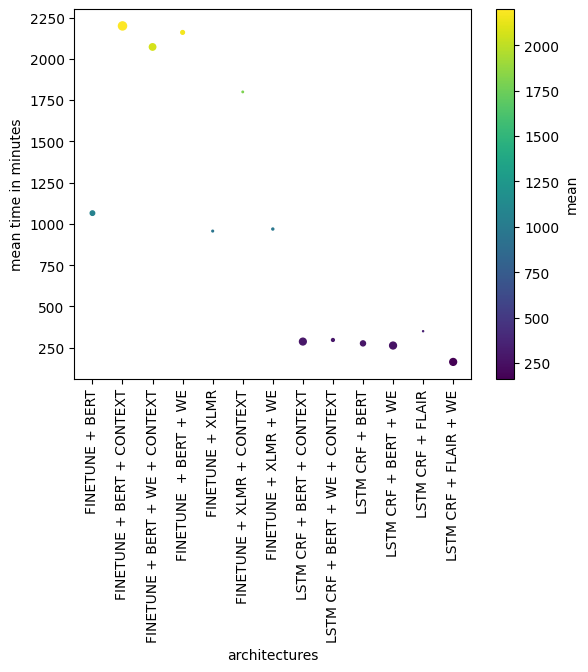

In [8]:
from pathlib import Path
import pandas as pd
from typing import List, Callable
from datetime import timedelta
from pandas import Timestamp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.axes import Axes


def get_training_time(pth: Path) -> Timestamp:
    """Compute the training time by reading the loss.tsv file produce by Flair
    training function.

    Args:
        pth (Path): Path to the loss.tsv file.

    Returns:
        Timestamp: Training time.
    """
    df = pd.read_csv(pth, sep="\t")
    new: List[Timestamp] = []
    old = pd.to_datetime(df["TIMESTAMP"], unit="ns")
    days = 0
    for i, t in enumerate(old):
        if i > 0 and t.hour < new[i - 1].hour:
            days += 1
        new.append(t + timedelta(hours=24 * days))
    total_time = np.ptp(new)
    return total_time


def collect_training_times(
    seeds: List[int], get_pth: Callable[[int], str], name: str = None
):
    training_time: List[Timestamp] = []
    for seed in seeds:
        pth = get_pth(seed)
        training_time.append(get_training_time(pth))
    return pd.DataFrame(training_time, columns=[name])


base = Path.cwd().parent / "experiments"

collect_results = {
    "FINETUNE + BERT": {
        "seeds": [1, 12, 33],
        "get_pth": lambda seed: base
        / f"corpus_sentence_bert_finetune_it_150/an_wh_rs_False_dpt_0_emb_beto-cased_FT_True_Ly_-1_seed_{seed}_lr_5e-06_it_150_bs_4_opti_AdamW_pjct_emb_False_sdl_LinearSchedulerWithWarmup_use_crf_False_use_rnn_False_wup_0.1/0/loss.tsv",
    },
    "FINETUNE + BERT + CONTEXT": {
        "seeds": [1, 12, 33],
        "get_pth": lambda seed: base
        / f"corpus_sentence_bert_context_finetune/an_wh_rs_False_dpt_0_emb_beto-cased-context_FT_True_Ly_-1_seed_{seed}_lr_5e-06_it_150_bs_4_opti_AdamW_pjct_emb_False_sdl_LinearSchedulerWithWarmup_use_crf_False_use_rnn_False_wup_0.1/0/loss.tsv",
    },
    "FINETUNE + BERT + WE + CONTEXT": {
        "seeds": [1, 12, 33],
        "get_pth": lambda seed: base
        / f"corpus_sentence_bert_context_we_finetune_it_150/an_wh_rs_False_dpt_0_emb_Stack(0_es-wiki-fasttext-300d-1M, 1_1-beto-cased_FT_True_Ly_-1_seed_{seed})_lr_5e-06_it_150_bs_4_opti_AdamW_pjct_emb_False_sdl_LinearSchedulerWithWarmup_use_crf_False_use_rnn_False_wup_0.1/0/loss.tsv",
    },
    "FINETUNE  + BERT + WE": {
        "seeds": [1, 12, 33],
        "get_pth": lambda seed: base
        / f"corpus_sentence_bert_we_finetune_it_150/an_wh_rs_False_dpt_0_emb_Stack(0_es-wiki-fasttext-300d-1M, 1_1-beto-cased_FT_True_Ly_-1_seed_{seed})_lr_5e-06_it_150_bs_4_opti_AdamW_pjct_emb_False_sdl_LinearSchedulerWithWarmup_use_crf_False_use_rnn_False_wup_0.1/0/loss.tsv",
    },
    "FINETUNE + XLMR": {
        "seeds": [1, 12, 33],
        "get_pth": lambda seed: base
        / f"corpus_sentence_xlmrl_finetune/an_wh_rs_False_dpt_0_emb_xlm-roberta-large-cased_FT_True_Ly_-1_seed_{seed}_lr_5e-06_it_40_bs_4_opti_AdamW_pjct_emb_False_sdl_LinearSchedulerWithWarmup_use_crf_False_use_rnn_False_wup_0.05/0/loss.tsv",
    },
    "FINETUNE + XLMR + CONTEXT": {
        "seeds": [1, 12, 33],
        "get_pth": lambda seed: base
        / f"corpus_sentence_xlmrl_context_finetune/an_wh_rs_False_dpt_0_emb_xlm-roberta-large-cased-context_FT_True_Ly_-1_seed_{seed}_lr_5e-06_it_40_bs_4_opti_AdamW_pjct_emb_False_sdl_LinearSchedulerWithWarmup_use_crf_False_use_rnn_False_wup_0.1/0/loss.tsv",
    },
    "FINETUNE + XLMR + WE": {
        "seeds": [1, 12, 33],
        "get_pth": lambda seed: base
        / f"corpus_sentence_xlmrl_we_finetune/an_wh_rs_False_dpt_0_emb_Stack(0_es-wiki-fasttext-300d-1M, 1_1-xlm-roberta-large-cased_FT_True_Ly_-1_seed_{seed})_lr_5e-06_it_40_bs_4_opti_AdamW_pjct_emb_False_sdl_LinearSchedulerWithWarmup_use_crf_False_use_rnn_False_wup_0.05/0/loss.tsv",
    },
    "LSTM CRF + BERT + CONTEXT": {
        "seeds": [1, 12, 33],
        "get_pth": lambda seed: base
        / f"corpus_sentence_bert_context_lstm_crf/an_wh_rs_False_dpt_0_emb_beto_Ly_all_mean_context_seed_{seed}_hdn_sz_256_lr_0.1_it_500_bs_4_opti_SGD_pjct_emb_False_rnn_ly_2_sdl_AnnealOnPlateau_use_crf_True_use_rnn_True/0/loss.tsv",
    },
    "LSTM CRF + BERT + WE + CONTEXT": {
        "seeds": [1, 12, 33],
        "get_pth": lambda seed: base
        / f"corpus_sentence_bert_context_we_lstm_crf/an_wh_rs_False_dpt_0_emb_Stack(0_es-wiki-fasttext-300d-1M, 1_1-beto_Ly_all_mean_context_seed_{seed})_hdn_sz_256_lr_0.1_it_500_bs_4_opti_SGD_pjct_emb_False_rnn_ly_2_sdl_AnnealOnPlateau_use_crf_True_use_rnn_True/0/loss.tsv",
    },
    "LSTM CRF + BERT": {
        "seeds": [1, 12, 33],
        "get_pth": lambda seed: base
        / f"corpus_sentence_bert_lstm_crf/an_wh_rs_False_dpt_0_emb_beto_Ly_all_mean_seed_{seed}_hdn_sz_256_lr_0.1_it_500_bs_4_opti_SGD_pjct_emb_False_rnn_ly_2_sdl_AnnealOnPlateau_use_crf_True_use_rnn_True/0/loss.tsv",
    },
    "LSTM CRF + BERT + WE": {
        "seeds": [1, 12, 33],
        "get_pth": lambda seed: base
        / f"corpus_sentence_bert_we_lstm_crf/an_wh_rs_False_dpt_0_emb_Stack(0_es-wiki-fasttext-300d-1M, 1_1-beto_Ly_all_mean_seed_{seed})_hdn_sz_256_lr_0.1_it_500_bs_4_opti_SGD_pjct_emb_False_rnn_ly_2_sdl_AnnealOnPlateau_use_crf_True_use_rnn_True/0/loss.tsv",
    },
    "LSTM CRF + FLAIR": {
        "seeds": [1, 12, 33],
        "get_pth": lambda seed: base
        / f"corpus_sentence_flair_lstm_crf/an_wh_rs_True_dpt_0.08716810045694838_emb_seed_{seed}_Stack(0_lm-es-forward.pt, 1_lm-es-backward.pt)_hdn_sz_256_lr_0.1_it_150_bs_4_opti_SGD_pjct_emb_True_rnn_ly_2_sdl_AnnealOnPlateau_use_crf_True_use_rnn_True/0/loss.tsv",
    },
    "LSTM CRF + FLAIR + WE": {
        "seeds": [1, 10, 42],
        "get_pth": lambda seed: base
        / f"corpus_sentence_flair_we_lstm_crf/results_seed_{seed}/loss.tsv",
    },
}
for k, v in collect_results.items():
    collect_results[k]["timestamp"] = collect_training_times(
        v["seeds"], v["get_pth"], k
    )

training_times = pd.concat(
    [collect_results[k]["timestamp"] for k in collect_results], axis=1
)


# plot
df = training_times.astype("timedelta64[m]").describe().T.reset_index()
ax: Axes = df.plot.scatter(
    "index",
    "mean",
    # yerr="std",
    use_index=True,
    rot="vertical",
    ylabel="mean time in minutes",
    xlabel="architectures",
    c="mean",
    s="std",
    colormap="viridis",
)

## Conclusión

El sistema basado en Transfer Learning y el uso de Transformadores (BERT / XLMR-Large) nos ha permitido obtener muy buenos resultados sobre el conjunto de datos MEDDOCAN, nos ha mostrado un score superior en comparación con el uso de las tecnologías precedentes como los embeddings contextuales de **Flair**.

No obstante esa mejora conlleva un tiempo de entrenamiento más largo así que modelos con más parámetros y entonces más voluminosos.

## La application web

In [ ]:
! streamlit run ../application/app.py

...

>:pencil: Para parar la aplicación podemos simplemente ejecutar el comando siguiente:
> ```console
> kill $(ps aux | grep streamlit | awk '{print $2}')
> ```

Test de la librería

In [ ]:
!cd .. && bash scripts/test-cov.sh